Added Quantization

In [54]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import copy
from scipy.stats import skew
import random
import pandas as pd

In [55]:
def seed_all(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
seed_all(42)

In [56]:
# Hyperparameters
batch_size = 128
epochs =3
beta = 0.95
# The beta defined here = (1 - delta(t)/Tau)
# Here delta(t) is the clk period
# Tau = Time constant = RC
# This is the approximation of beta = exp(-delta(t)/Tau)
num_steps = 25
no_of_conductance_levels = 20

In [57]:
# Perform learning over cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [58]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST("/home/neel/Sem_8/RnD/RnD_rough/data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST("/home/neel/Sem_8/RnD/RnD_rough/data", train=False, download=True, transform=transform)

In [59]:
# Loading the training and test data
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [60]:
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
data_it = data_it.view(batch_size, -1)
spike_data = spikegen.rate(data_it, num_steps=num_steps)
print(spike_data.shape)
#spike_data = (spike_data.view(num_steps,batch_size, -1))

torch.Size([25, 128, 784])


In [61]:
# Here we are creating a single hidden layer NN, with 150 nodes
class Net(nn.Module):
    def __init__(self, num_hidden_layer = 150):
        super().__init__()

        # Initialize layers
        self.linear_1 = nn.Linear(in_features=784,out_features=num_hidden_layer,bias=False)
        self.lif1 = snn.Leaky(beta=beta,reset_mechanism= "zero")
        self.linear_2 = nn.Linear(in_features=num_hidden_layer, out_features=10, bias=False)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        spk1_rec = []

        x = spikegen.rate(x, num_steps=num_steps)

        for step in range(num_steps):
            cur1 = self.linear_1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            cur2 = self.linear_2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0) , torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
num_hidden_layer = 150
model = Net(num_hidden_layer=num_hidden_layer).to(device)
next(model.parameters()).is_cuda


True

In [62]:
import torch.nn.functional as F
LAMBDA = 3
def cross_entropy_loss(outputs,targets):
    return(F.cross_entropy(outputs,targets))

def penalty_term(model,threshold):
    penalty = 0.0
    for p in model.parameters():
        penalty+=torch.sum(torch.clamp(p.abs()-threshold,min=0))
        return penalty

def custom_loss(outputs,targets,model, threshold, lambda_):
    ce_loss = cross_entropy_loss(outputs,targets)
    penalty = penalty_term(model,threshold)
    return(ce_loss + lambda_*penalty)

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [64]:
def accuracy():
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, label in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            label = label.to(device)

            # Test set forward pass
            _, test_spk, test_mem = model(images.view(batch_size, -1))
            n_samples += label.size(0)
            _, idx = test_spk.sum(dim=0).max(1)
            n_correct+= (label == idx).sum().item()
            return(n_correct/n_samples * 100)

Max condutance 0.1261589403973509
Min condutance 0.0221854304635761


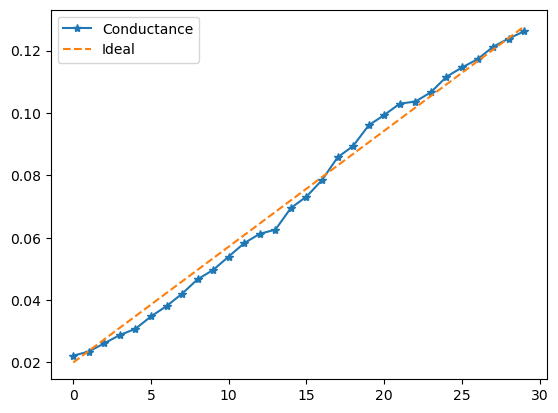

In [65]:
a = pd.read_csv("/home/neel/Sem_8/RnD/quantization/plot-data.csv")
conductance = np.array(a.iloc[:,1])
plt.plot(conductance,'-*')
y = (0.13/35 * np.arange(len(conductance)))+0.02
plt.plot(y,'--')
plt.legend(["Conductance","Ideal"])
print("Max condutance", np.max(conductance))
print("Min condutance", np.min(conductance))
conductance = np.concatenate((-1*conductance,conductance))

In [66]:
def conductance_quantization(size):
    conductance_torch = np.zeros((size[0],size[1],len(conductance)))
    for i in range(len(conductance)):
        conductance_torch[:,:,i].fill(conductance[i])
    conductance_torch = torch.Tensor(conductance_torch).to(device)
    return(conductance_torch)

In [67]:
conductance_quantization_layer_1 = conductance_quantization((num_hidden_layer,784))
conductance_quantization_layer_2 = conductance_quantization((10,150))
def quantization(layer_1 = True, layer_2 = True):
    if(layer_1):
        with torch.no_grad():
            A = model.linear_1.weight
            A_temp = A.unsqueeze(2).repeat(1,1,len(conductance))
            B = torch.abs(conductance_quantization_layer_1 - A_temp)
            idx = torch.argmin(B,dim=2)
            idx = idx.unsqueeze(2)
            model.linear_1.weight = torch.nn.Parameter(conductance_quantization_layer_1.gather(2,idx).squeeze())
        
    if(layer_2):
        with torch.no_grad():
            A = model.linear_2.weight
            A_temp = A.unsqueeze(2).repeat(1,1,len(conductance))
            B = torch.abs(conductance_quantization_layer_2 - A_temp)
            idx = torch.argmin(B,dim=2)
            idx = idx.unsqueeze(2)
            model.linear_2.weight = torch.nn.Parameter(conductance_quantization_layer_2.gather(2,idx).squeeze())

In [68]:
%%time
stashed_global = []
stashed_lin1_wt_dict = {}
stashed_lin1_bias_dict = {}
stashed_lin2_wt_dict = {}
threshold = 25
accuracy_plot = []
stashing_location = []
iteration = 0
univ = [i for i in range(num_hidden_layer)]
#spk1_freq_temp = torch.empty((batch_size,num_hidden_layer)).to(device)
n_total_steps = len(train_loader)*epochs
stashing_freq = 250
stop_stashing_index = stashing_freq * (n_total_steps//stashing_freq)


for epoch_iter in range(epochs):
    spk1_freq_temp = torch.empty((batch_size,num_hidden_layer)).to(device)


    for i,(data, target) in enumerate(train_loader):
        iteration+=1
        x = data.to(device)
        y = target.to(device)
        spk1_rec, spk_rec, mem_rec = model(x.view(batch_size, -1))
        spk1_rec = torch.sum(spk1_rec, 0)
        spk1_freq_temp = torch.cat((spk1_freq_temp, spk1_rec))
        loss_val = torch.zeros((1),device=device)
        for step in range(num_steps):
            loss_val += custom_loss(mem_rec[step],y,model,threshold=0.12, lambda_ = LAMBDA)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        if((iteration) % 1 == 0):
            accuracy_plot.append(accuracy())

        if (iteration) % 50 == 0:
            print (f'Epoch [{epoch_iter+1}/{epochs}], Step[{iteration}/{(n_total_steps)}], Loss: {loss_val.item():.4f}')
            print("-------------------------")
        
        if((iteration<stop_stashing_index) and (iteration) % stashing_freq == 0):
            stashed = []
            stashing_location.append(iteration)
            print("Accuracy before stashing", accuracy())
            for j in univ:
                if(spk1_freq_temp[-1,j]>threshold):
                    stashed.append(j)
                    stashed_global.append(j)
            for k in stashed:
                stashed_lin1_wt_dict[k] =model.linear_1.weight[k,:].clone().detach()
                #stashed_lin1_bias_dict[k] = model.linear_1.bias[k].clone().detach()
                stashed_lin2_wt_dict[k] = model.linear_2.weight[:,k].clone().detach()
            
            print("Node stashed", stashed)
            print("-------------------------")
            univ = [i for i in univ if i not in stashed]
        
        if(iteration<=stop_stashing_index):
            for k in stashed_global:
                with torch.no_grad():
                    model.linear_1.weight[k,:] = 0
                    #model.linear_1.bias[k] = 0
                    model.linear_2.weight[:,k] = 0
            
            if((iteration) % stashing_freq == 0):
                print("Accuracy after_stashing is", accuracy())
        
        if(iteration == stop_stashing_index):
            print("Joined all the stashed nodes")
            for i in stashed_global:
                assert model.linear_2.weight[:,i].any() == False
                assert model.linear_1.weight[i,:].any() == False
                #assert model.linear_1.bias[i] == 0
            print("Assertions Passed")
            with torch.no_grad():
                for key in stashed_lin1_wt_dict:
                    model.linear_1.weight[key,:] = stashed_lin1_wt_dict[key]
                    #model.linear_1.bias[key] = stashed_lin1_bias_dict[key]
                    model.linear_2.weight[:,key] = stashed_lin2_wt_dict[key]
        
print("Total nodes stashed", len(stashed_global))
        

Epoch [1/3], Step[50/1404], Loss: 24.2315
-------------------------
Epoch [1/3], Step[100/1404], Loss: 15.4179
-------------------------
Epoch [1/3], Step[150/1404], Loss: 12.1270
-------------------------
Epoch [1/3], Step[200/1404], Loss: 10.5617
-------------------------
Epoch [1/3], Step[250/1404], Loss: 10.9298
-------------------------
Accuracy before stashing 92.1875
Node stashed []
-------------------------
Accuracy after_stashing is 93.75
Epoch [1/3], Step[300/1404], Loss: 8.8078
-------------------------
Epoch [1/3], Step[350/1404], Loss: 15.7079
-------------------------
Epoch [1/3], Step[400/1404], Loss: 10.9542
-------------------------
Epoch [1/3], Step[450/1404], Loss: 6.7401
-------------------------
Epoch [2/3], Step[500/1404], Loss: 9.4609
-------------------------
Accuracy before stashing 92.96875
Node stashed []
-------------------------
Accuracy after_stashing is 90.625
Epoch [2/3], Step[550/1404], Loss: 8.6883
-------------------------
Epoch [2/3], Step[600/1404],

In [69]:
quantization()
print(accuracy())
accuracy_plot.append(accuracy())

89.84375


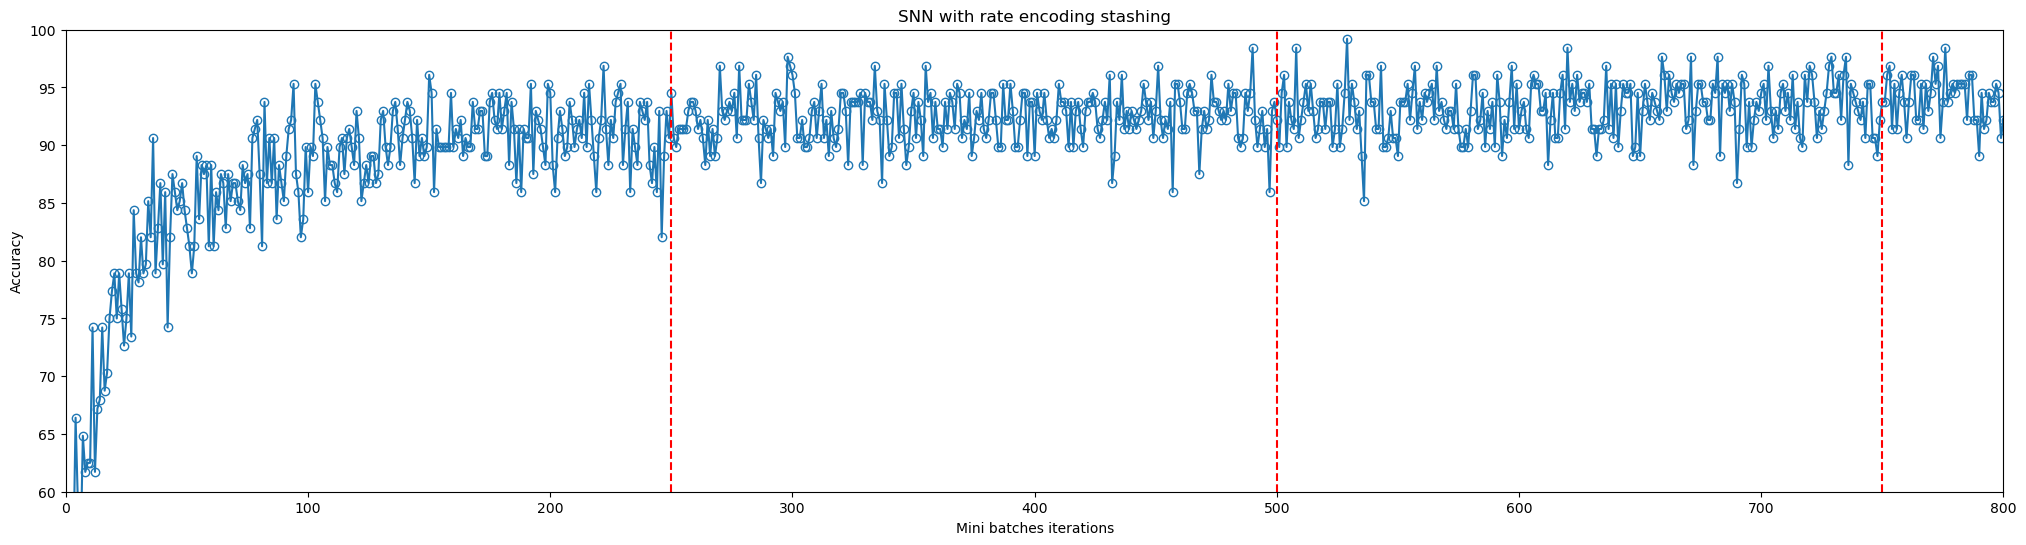

In [70]:
plt.figure(figsize=(25,6))
plt.plot(accuracy_plot,'-o',markerfacecolor='none')
plt.ylim([60,100])
plt.xlim([0,800])
plt.title("SNN with rate encoding stashing")
plt.xlabel("Mini batches iterations")
plt.ylabel("Accuracy")
for i in stashing_location:
    plt.axvline(x=i,color='r',linestyle='--')

In [71]:
layer1_wts = model.linear_1.weight[:,:].cpu().clone().detach().numpy()
temp_layer_1_wts = model.linear_1.weight[:,:].cpu().clone().detach().numpy()

layer2_wts = model.linear_2.weight[:,:].cpu().clone().detach().numpy()
temp_layer_2_wts = model.linear_2.weight[:,:].cpu().clone().detach().numpy()

In [72]:
# np.max(np.abs(layer1_wts),axis=1)
# plt.hist(np.abs(layer1_wts[4,:]))

Max weight value is 0.12119205
Min weight value is -0.12119205
taking avg 0.12119205296039581


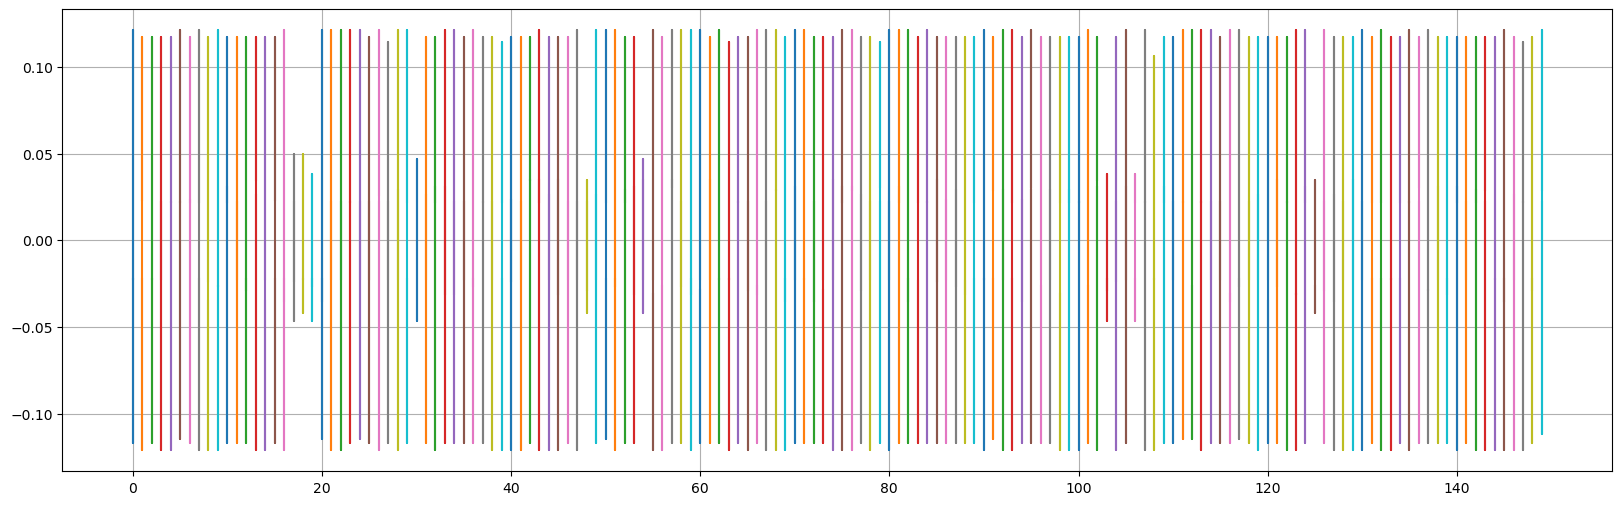

In [73]:
plt.figure(figsize=(20,6))
# plt.yticks(np.arange(min(layer1_wts.flatten()),max(layer1_wts.flatten()),0.15))
for i,data in enumerate(layer1_wts):
    plt.plot([i]*len(data), data)
plt.grid()
max_wt_layer_1 = max(layer1_wts.flatten())
min_wt_layer_1 = min(layer1_wts.flatten())
avg_max_wt_layer_1 = (abs(max_wt_layer_1) + abs(min_wt_layer_1))/2
print("Max weight value is", max_wt_layer_1)
print("Min weight value is", min_wt_layer_1)
print("taking avg", avg_max_wt_layer_1)
plt.show()

Max weight value is 0.12615894
Min weight value is -0.12615894
taking avg 0.1261589378118515


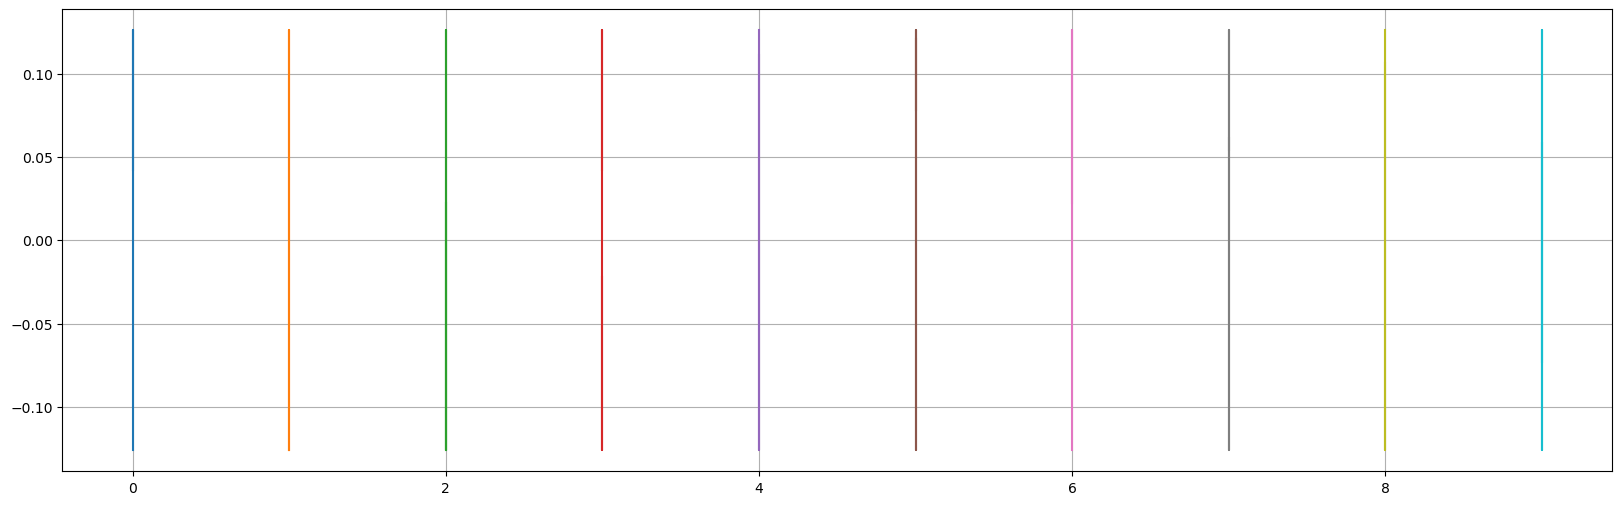

In [74]:
plt.figure(figsize=(20,6))
# plt.yticks(np.arange(min(layer2_wts.flatten()),max(layer2_wts.flatten()),0.15))
for i,data in enumerate(layer2_wts):
    plt.plot([i]*len(data), data)
plt.grid()
max_wt_layer_2 = max(layer2_wts.flatten())
min_wt_layer_2 = min(layer2_wts.flatten())
avg_max_wt_layer_2 = (abs(max_wt_layer_2) + abs(min_wt_layer_2))/2
print("Max weight value is", max_wt_layer_2)
print("Min weight value is", min_wt_layer_2)
print("taking avg", avg_max_wt_layer_2)
plt.show()

In [75]:
spk1_freq = spk1_freq_temp[batch_size:,:]
spk1_freq = spk1_freq.cpu().detach().numpy()

Total stashed 0


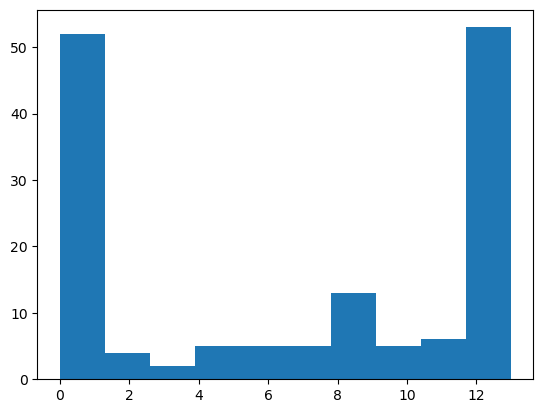

In [76]:
# Calculating the statistics of our spikes
mean_all_node = np.mean(spk1_freq,axis=0)
std_dev_all_node = np.std(spk1_freq,axis=0)
successive_dif_all_node = np.diff(spk1_freq, axis=0)
print("Total stashed", len(stashed_global))
plt.hist(spk1_freq[-1,:])
skew_all_node = skew(spk1_freq,axis=0)


In [77]:
np.savez('accuracy_normal.npz',np.array(accuracy_plot))